In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds

In [2]:
ratings_url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
movies_url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.item"

ratings = pd.read_csv(ratings_url, sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
movies = pd.read_csv(movies_url, sep="|", encoding='latin-1', header=None, usecols=[0, 1], names=["item_id", "title"])

In [3]:
ratings.drop("timestamp", axis=1, inplace=True)
data = pd.merge(ratings, movies, on="item_id")
user_item_matrix = data.pivot_table(index="user_id", columns="item_id", values="rating")

In [5]:
user_similarity = cosine_similarity(user_item_matrix.fillna(0))
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

def recommend_movies_user_based(user_id, n_recommendations=5):
    similar_users = user_similarity_df[user_id].drop(user_id).sort_values(ascending=False)
    weighted_ratings = pd.Series(dtype=np.float64)
    for other_user, similarity_score in similar_users.items():
        other_user_ratings = user_item_matrix.loc[other_user]
        weighted_ratings = weighted_ratings.add(other_user_ratings * similarity_score, fill_value=0)
    user_seen = user_item_matrix.loc[user_id].dropna().index
    recommendations = weighted_ratings.drop(user_seen).sort_values(ascending=False).head(n_recommendations)
    return movies[movies["item_id"].isin(recommendations.index)]["title"].values

In [6]:
item_similarity = cosine_similarity(user_item_matrix.fillna(0).T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

def recommend_movies_item_based(user_id, n_recommendations=5):
    user_ratings = user_item_matrix.loc[user_id].dropna()
    scores = pd.Series(dtype=np.float64)
    for item_id, rating in user_ratings.items():
        similarity_scores = item_similarity_df[item_id]
        scores = scores.add(similarity_scores * rating, fill_value=0)
    scores = scores.drop(user_ratings.index, errors='ignore')
    recommendations = scores.sort_values(ascending=False).head(n_recommendations)
    return movies[movies["item_id"].isin(recommendations.index)]["title"].values

In [9]:
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)
train_matrix = train_data.pivot(index="user_id", columns="item_id", values="rating").fillna(0)
U, sigma, Vt = svds(train_matrix.values, k=20)
sigma = np.diag(sigma)
predicted_ratings = np.dot(np.dot(U, sigma), Vt)
svd_preds = pd.DataFrame(predicted_ratings, index=train_matrix.index, columns=train_matrix.columns)

In [10]:
def recommend_movies_svd(user_id, n_recommendations=5):
    user_row = svd_preds.loc[user_id]
    user_seen = train_matrix.loc[user_id][train_matrix.loc[user_id] > 0].index
    recommendations = user_row.drop(user_seen).sort_values(ascending=False).head(n_recommendations)
    return movies[movies["item_id"].isin(recommendations.index)]["title"].values

In [11]:
def precision_at_k(actual, predicted, k):
    predicted_k = predicted[:k]
    actual_set = set(actual)
    predicted_set = set(predicted_k)
    return len(actual_set & predicted_set) / k

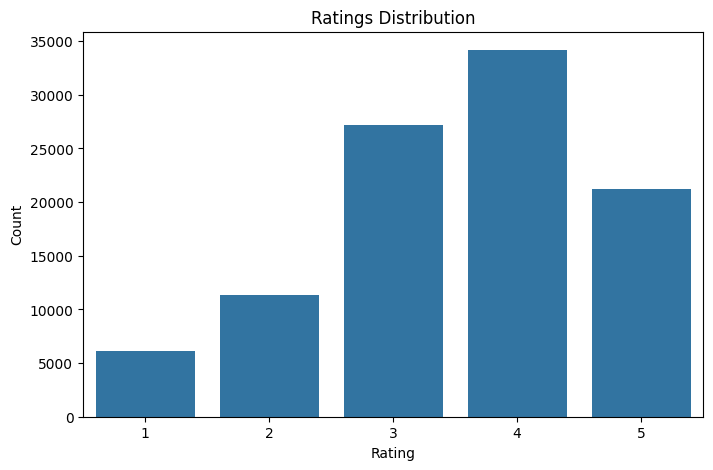

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x="rating", data=ratings)
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

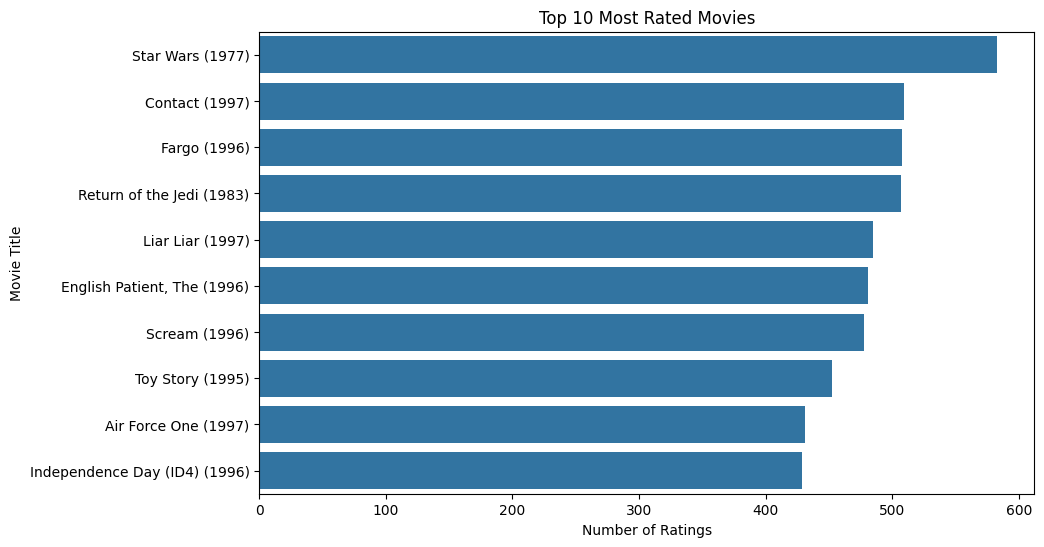

In [13]:
top_movies = data.groupby("title").size().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_movies.values, y=top_movies.index)
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.show()

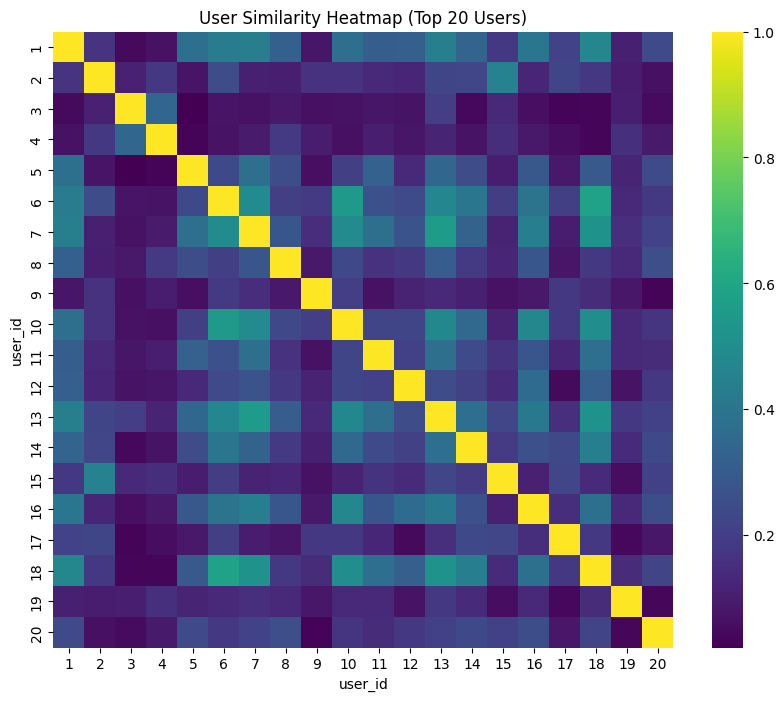

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(user_similarity_df.iloc[:20, :20], cmap="viridis")
plt.title("User Similarity Heatmap (Top 20 Users)")
plt.show()

In [15]:
user_id = 10

print("User-based Recommendations:")
print(recommend_movies_user_based(user_id))

print("\nItem-based Recommendations:")
print(recommend_movies_item_based(user_id))

print("\nSVD-based Recommendations:")
print(recommend_movies_svd(user_id))

User-based Recommendations:
['Fugitive, The (1993)' 'Empire Strikes Back, The (1980)'
 'Return of the Jedi (1983)' 'Back to the Future (1985)'
 "Schindler's List (1993)"]

Item-based Recommendations:
['Fugitive, The (1993)' 'Blade Runner (1982)'
 'Empire Strikes Back, The (1980)' 'Back to the Future (1985)'
 'E.T. the Extra-Terrestrial (1982)']

SVD-based Recommendations:
['Usual Suspects, The (1995)' 'Godfather, The (1972)'
 'Secrets & Lies (1996)' 'Casablanca (1942)' 'Annie Hall (1977)']


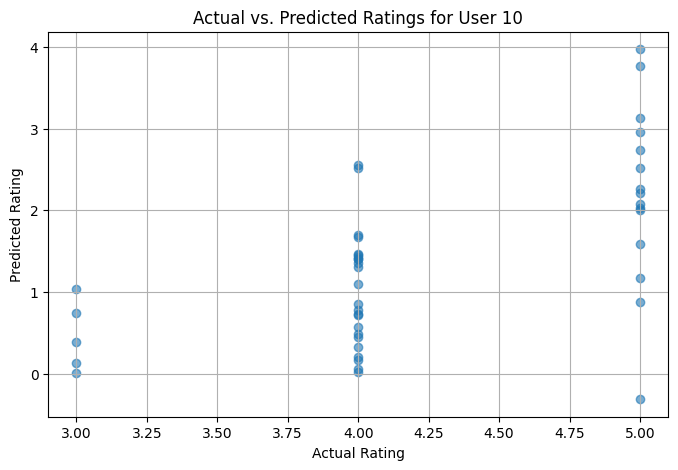

In [16]:
actual_user = test_data[test_data["user_id"] == user_id]
predicted_user = svd_preds.loc[user_id].reindex(actual_user["item_id"]).values

plt.figure(figsize=(8, 5))
plt.scatter(actual_user["rating"], predicted_user, alpha=0.6)
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title(f"Actual vs. Predicted Ratings for User {user_id}")
plt.grid(True)
plt.show()